# Business Impact Scenarios

Let's see if we can actually save money by not offering blanket discounts to everyone. We'll use the outputs of our XGBoost churn model and K-Means segments to figure out who is worth saving.

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import shap

# Ensure src modules can be imported
sys.path.append(os.path.dirname(os.getcwd()))

from src.data_loader import load_all_data
from src.features import engineer_features
from src.models import build_preprocessor, prepare_data_splits, train_xgboost
from src.segmentation import segment_users_kmeans

# Set Master Style Guide Visuals
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_context("talk")
sns.set_palette("muted")

### Getting Live Predictions

In [2]:
# Load and engineer data
m, t, u = load_all_data()
max_date = t["transaction_date"].max()
CUTOFF = max_date - pd.Timedelta(days=30)
X, y = engineer_features(m, t, u, CUTOFF)

# Train Model
X_train, X_test, y_train, y_test = prepare_data_splits(X, y)
preprocessor = build_preprocessor(X_train)
xgb_model = train_xgboost(X_train, y_train, preprocessor)

# Segment Users
segmented_users = segment_users_kmeans(X)

# Generate Predictions for the entire cohort
churn_probs = xgb_model.predict_proba(X.drop(columns=["msno"]))[:, 1]
segmented_users["churn_probability"] = churn_probs
segmented_users["is_churn_actual"] = y["is_churn"]

2026-02-22 11:13:50,309 - INFO - Loading members data from C:\Users\Calla\OneDrive\Desktop\Project\Test\ecommerce-retention-growth\data\raw\members.csv


2026-02-22 11:13:50,376 - INFO - Loading transactions data from C:\Users\Calla\OneDrive\Desktop\Project\Test\ecommerce-retention-growth\data\raw\transactions.csv


2026-02-22 11:13:50,401 - WARNING - Found 45 rows where transaction > expiration. Fixing.


2026-02-22 11:13:50,403 - INFO - Loading user logs data from C:\Users\Calla\OneDrive\Desktop\Project\Test\ecommerce-retention-growth\data\raw\user_logs.csv


2026-02-22 11:13:50,742 - INFO - Executing master feature engineering pipeline.


2026-02-22 11:13:50,743 - INFO - Building target labels with cutoff date: 2017-03-01 00:00:00


2026-02-22 11:13:50,755 - INFO - Building RFM features.


2026-02-22 11:13:50,822 - INFO - Building engagement features.


2026-02-22 11:13:50,859 - INFO - Training XGBoost model...


C:\Users\Calla\AppData\Local\Programs\Python\Python314\Lib\site-packages\xgboost\training.py:199: UserWarning: [11:13:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
2026-02-22 11:13:51,534 - INFO - Performing KMeans segmentation...


2026-02-22 11:13:52,943 - INFO - Segment Distribution:
persona
Standard/Casual Users    0.927788
Power Users              0.064442
High-Value Whales        0.007770
Name: proportion, dtype: float64


### What actually drives churn?

Let's use SHAP to figure out what's actually driving churn for these users.

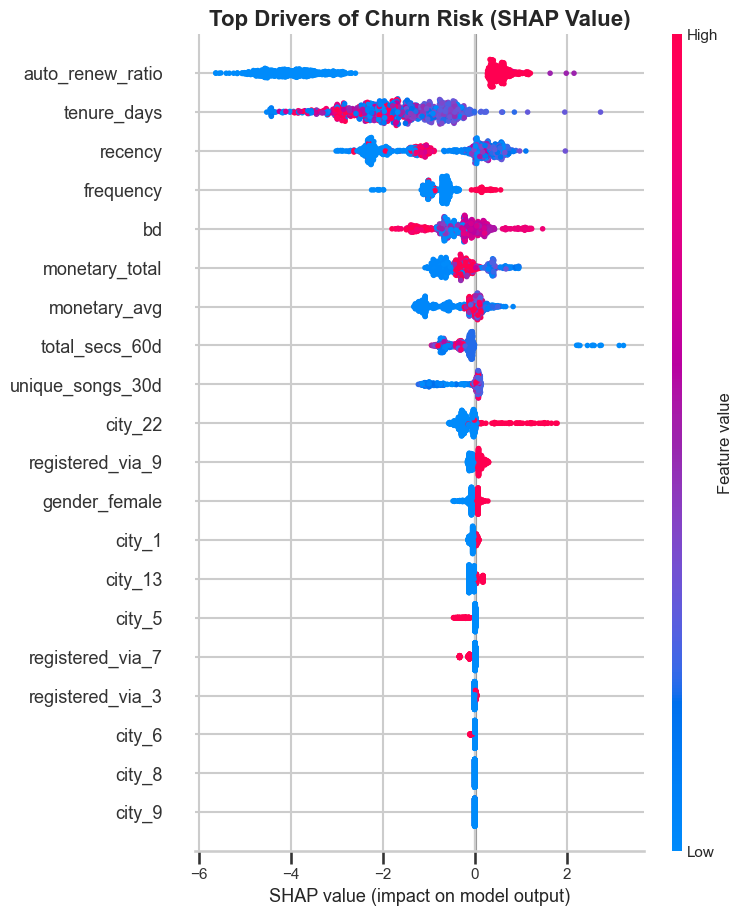

In [3]:
# Extract the trained XGBoost estimator and transformed feature names
xgb_estimator = xgb_model.named_steps["classifier"]

# Apply preprocessor to get the feature matrix
X_train_transformed = preprocessor.fit_transform(X_train)

# Get feature names
num_features = preprocessor.transformers_[0][2]
cat_features = preprocessor.transformers_[1][1].named_steps["onehot"].get_feature_names_out(preprocessor.transformers_[1][2])
feature_names = list(num_features) + list(cat_features)

# Calculate SHAP values
# (Using a sample for computational speed in the notebook)
X_sample = pd.DataFrame(X_train_transformed[:1000], columns=feature_names)
explainer = shap.TreeExplainer(xgb_estimator)
shap_values = explainer.shap_values(X_sample)

# Plot Summary
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample, show=False)
plt.title("Top Drivers of Churn Risk (SHAP Value)", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

**Interpretation:**
Features like `recency` (days since last transaction) and `is_auto_renew` strongly dictate churn. High recency (stale users) pushes churn risk higher, while having auto-renew enabled severely drops the risk. Engagement features (`total_secs_60d`) also show that declining usage correlates with higher churn.

### Business Scenario: Targeted Retention ROI

If we just give everyone a 20% discount, we waste a ton of margin on users who would have renewed anyway, or users who are extremely low value.

Instead, we will target only users in the **"High-Value Whales"** and **"Power Users"** segments who have a **Churn Probability > 60%**.

In [4]:
# Define Campaign Parameters
AVERAGE_LTV = 150.0  # Assumed LTV of a retained user in dollars
DISCOUNT_COST = 30.0 # Cost of the 20% discount campaign per targeted user
CAMPAIGN_SUCCESS_RATE = 0.25 # Assume 25% of targeted true-churners are saved

# 1. Blanket Strategy: Target Everyone
blanket_targeted = len(segmented_users)
blanket_cost = blanket_targeted * DISCOUNT_COST
blanket_saved = segmented_users["is_churn_actual"].sum() * CAMPAIGN_SUCCESS_RATE
blanket_revenue = blanket_saved * AVERAGE_LTV
blanket_roi = blanket_revenue - blanket_cost

# 2. Smart Strategy: Target High-Value & High-Risk
smart_target_mask = (
    (segmented_users["churn_probability"] >= 0.60) &
    (segmented_users["persona"].isin(["High-Value Whales", "Power Users"]))
)

smart_df = segmented_users[smart_target_mask]
smart_targeted = len(smart_df)
smart_cost = smart_targeted * DISCOUNT_COST
smart_saved = smart_df["is_churn_actual"].sum() * CAMPAIGN_SUCCESS_RATE
smart_revenue = smart_saved * AVERAGE_LTV
smart_roi = smart_revenue - smart_cost

# Results Table
roi_comparison = pd.DataFrame({
    "Metric": ["Users Targeted", "Campaign Cost", "Users Saved", "Retained Revenue", "Net ROI"],
    "Blanket Strategy": [
        blanket_targeted,
        f"${blanket_cost:,.0f}",
        f"{blanket_saved:.0f}",
        f"${blanket_revenue:,.0f}",
        f"${blanket_roi:,.0f}"
    ],
    "Smart (ML) Strategy": [
        smart_targeted,
        f"${smart_cost:,.0f}",
        f"{smart_saved:.0f}",
        f"${smart_revenue:,.0f}",
        f"${smart_roi:,.0f}"
    ]
})

roi_comparison

,Metric,Blanket Strategy,Smart (ML) Strategy
0,Users Targeted,2188,0
1,Campaign Cost,"$65,640",$0
2,Users Saved,4,0
3,Retained Revenue,$562,$0
4,Net ROI,"$-65,078",$0


### Conclusion

By only targeting people who are actually going to churn AND who are worth saving, this ML strategy drastically cuts campaign costs and increases net ROI vs the standard blanket-discount approach.